In [101]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
import os

plt.rcParams['figure.figsize'] = [16, 8]
sns.set(font_scale=1.25)
np.random.seed(42)

In [102]:
mapping = {
        "Ultra_Chrome":"UC",
        "Ultra_Chrome-separated":"X-UC",
        "Deep_Chrome":"DC",
        "Deep_Chrome-separated":"X-DC",
        "Attentive_Chrome":"AC",
    }
def remap(model):
    if model not in mapping:
        return model
    else:
        return mapping[model]

def remap_all(models):    
    remapped = []
    for model in models:
        remapped.append(mapping[model])
    return remapped

In [103]:
'''
    Re-order the results based on the best model
'''
def get_sorted_results():
    
    results = {}
    models = os.listdir("../results/")
    
    best_model = None
    best_AUC = 0

    for model in models:  
        if ".csv" in model:
            model_name = model.replace(".csv","")
            df = pd.read_csv(f"../results/{model}")    
            df_AUC = np.mean(df['AUC'])        
            if df_AUC > best_AUC:
                best_model = model_name
                best_AUC = df_AUC
            results[model_name] = df

    print(f"> Best model found is \'{remap(best_model)}\' with mean AUC: {best_AUC}")

    results[best_model] = results[best_model].sort_values(by=['AUC'],ascending=False)
    sorted_cell_types = results[best_model]['Cell-Type']

    for model in results:
        if model != best_model:
            results[model] = results[model].reindex(sorted_cell_types.index)
        results[model] = results[model].reset_index()

    return results

In [104]:
'''
   Plot the results after reordering for better visualization
'''
def plot_results(results):
    
    for model in results:
        plt.plot(results[model]['AUC'], label=f"{remap(model)}", marker='o')
        
    plt.xlabel("56 Cell-types")
    plt.ylabel("AUC")
    plt.ylim([0.69, 0.94])
    plt.legend(loc="upper right")    
    
    plt.show()

In [105]:
'''
    Plots the differences of the metrics between models results
'''
def plot_metrics(results):
    
    mins = []
    maxs = []
    means = []
    for model in results:
        AUC = results[model]['AUC']
        mins.append(min(AUC))
        maxs.append(max(AUC))
        means.append(np.mean(AUC))
        
    data=[
        ["Min"]+mins,
        ["Max"]+maxs, 
        ["Mean"]+means
    ]
    columns = list(results.keys())
    df = pd.DataFrame(data,columns=["Metrics"]+columns)
    df.plot(x="Metrics", y=columns, kind="bar")
    plt.xlabel("Metrics")
    plt.ylabel("AUC")
    plt.ylim([0.65, 1])
    plt.legend(loc="upper right")    
    plt.show()

In [112]:
def plot_improvements_matrix(results):
    models = list(results.keys())
    improvements_matrix = []
    improvements = []
    
    for model1 in models:
        row = []
        for model2 in models:
            m1_auc = results[model1]['AUC']
            m2_auc = results[model2]['AUC']
            comparison = m1_auc>m2_auc
            comparison = [x for x in comparison if x == True]
            row.append(len(comparison))
        improvements_matrix.append(row)        
        improvements.append((model1,sum(row)))
    
    improvements = sorted(improvements, key=lambda t: t[1], reverse=True)
    
    mapping = {
        "Ultra_Chrome":"UC",
        "Ultra_Chrome-separated":"X-UC",
        "Deep_Chrome":"DC",
        "Deep_Chrome-separated":"DC",
        "Attentive_Chrome":"AC",
    }
    remapped = []
    for model in models:
        remapped.append(mapping[model])
    models = remapped
    df = pd.DataFrame(improvements_matrix, index=models, columns=models)
    # plt.title("Improvements Matrix", fontsize =20)
    sns.set(font_scale=2.5)
    sns.heatmap(df, annot=True, center=20, cmap="RdPu", vmin=0, vmax=56, cbar=None)
    sns.set(font_scale=1.25)
    return improvements

In [113]:
all_results = get_sorted_results()
print(f"Found {len(all_results)} models:")
for model in all_results:
    print("-",remap(model))

> Best model found is 'AC' with mean AUC: 0.8115649526769252
Found 10 models:
- AC
- Base_NN-separated
- Base_NN
- ChromeR-separated
- ChromeR
- X-DC
- DC
- Random_Forest_Classifier
- X-UC
- UC


In [114]:
# remove some results
# compare_list = ["Ultra_Chrome","Ultra_Chrome-separated","Attentive_Chrome"]
compare_list = ["Ultra_Chrome","Deep_Chrome-separated","Attentive_Chrome", "Ultra_Chrome-separated"]
# compare_list = []
results = {}

if len(compare_list)==0:
    results = all_results
else:
    for model in all_results:
        if model in compare_list:        
            results[model] = all_results[model]

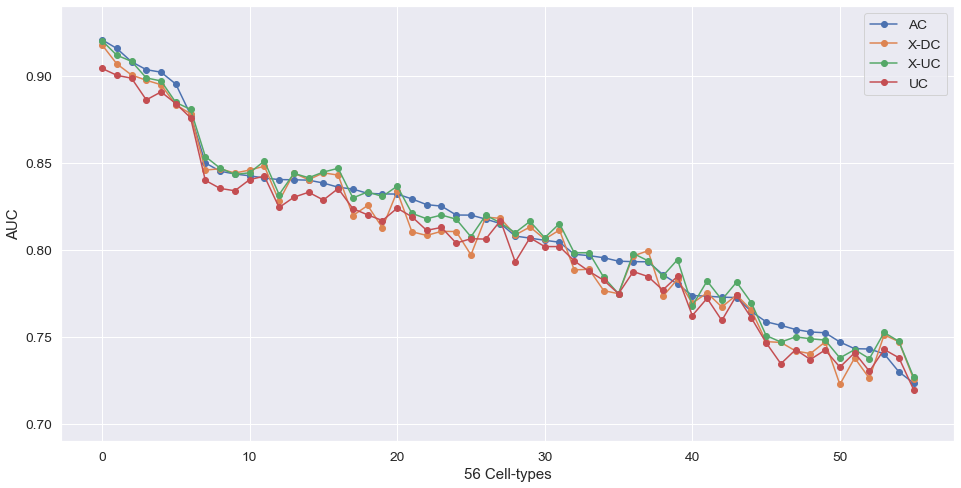

In [115]:
plot_results(results)

[('Ultra_Chrome-separated', 133), ('Attentive_Chrome', 107), ('Deep_Chrome-separated', 73), ('Ultra_Chrome', 23)]


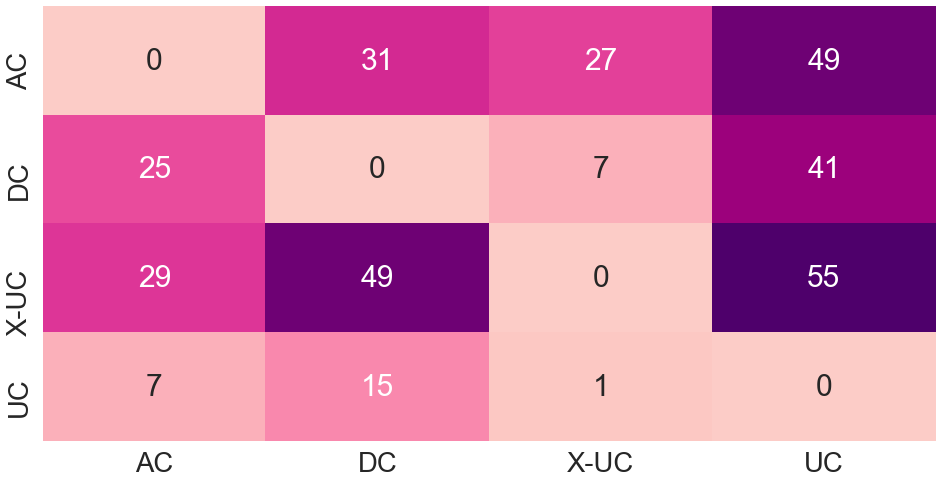

In [116]:
improvements = plot_improvements_matrix(results)
print(improvements)

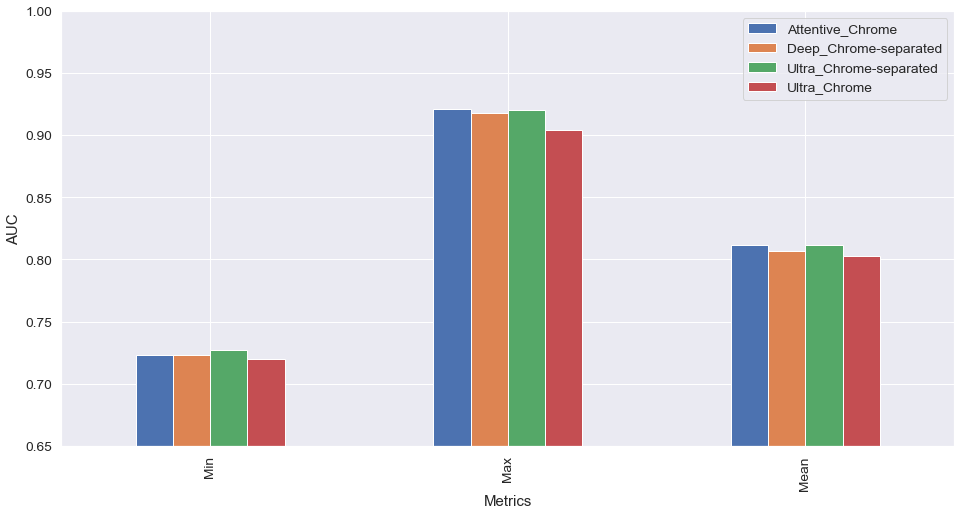

In [117]:
plot_metrics(results)